In [39]:
from bs4 import BeautifulSoup
import requests
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from num2words import num2words
import numpy as np
import pandas as pd
import math

In [40]:
def convert_lower_case(data):
    return np.char.lower(data)


def remove_stop_words(data):
    stop_words = stopwords.words('english')
    words = word_tokenize(str(data))
    new_text = ""
    for w in words:
        if w not in stop_words and len(w) > 1:
            new_text = new_text + " " + w
    return new_text


def remove_punctuation(data):
    symbols = "!\"#$%&()*+-./:;<=>?@[\]^_`{|}~\n"
    for i in range(len(symbols)):
        data = np.char.replace(data, symbols[i], ' ')
        data = np.char.replace(data, "  ", " ")
    data = np.char.replace(data, ',', '')
    return data


def remove_apostrophe(data):
    return np.char.replace(data, "'", "")


def convert_numbers(data):
    tokens = word_tokenize(str(data))
    new_text = ""
    for w in tokens:
        try:
            w = num2words(int(w))
        except:
            pass
        new_text = new_text + " " + w
    new_text = np.char.replace(new_text, "-", " ")
    return new_text


def preprocess(data):
    data = convert_lower_case(data)
    data = remove_punctuation(data)  # remove comma separately
    data = remove_apostrophe(data)
    data = remove_stop_words(data)
    data = convert_numbers(data)
    data = remove_punctuation(data)
    data = convert_numbers(data)
    data = remove_punctuation(data)  # needed again as num2word is giving few hyphens and commas forty-one
    return data

In [41]:

# code starts
links = [
  'https://en.wikipedia.org/wiki/Valorant',
  'https://en.wikipedia.org/wiki/Counter-Strike:_Global_Offensive',
  'https://en.wikipedia.org/wiki/Mobile_Legends:_Bang_Bang',
]

top_result = 10
word_idf = {}
words_ = set()
document = []

In [42]:
for article in links:
    source = requests.get(article).text
    soup = BeautifulSoup(source, 'lxml')
    current_article = {}
    for paragraph in soup.find_all('p'):
        preprocessed_text = str(preprocess(paragraph.text))

        for word in word_tokenize(preprocessed_text):
            word = word.lower()
            if word not in words_:
                words_.add(word)
            if not word:
                continue
            if word not in current_article:
                current_article[word] = 0
            current_article[word] += 1

    document.append(current_article)

n = len(document)

In [43]:
for word in words_:
    is_found = 0
    for article in document:
        if word in article:
            is_found += 1
    word_idf[word] = math.log(n / is_found)

tf_idf = []



In [44]:
for word, idf in word_idf.items():
    tdf_if_sum = 0
    for article in document:
        if word in article:
            tdf_if_sum += word_idf[word] * article[word] / len(article)
    tf_idf.append([word, tdf_if_sum])

tf_idf.sort(key=lambda x: -x[1])

top_rank = []
for i in range(top_result):
    top_rank.append([tf_idf[i][0], tf_idf[i][1]])

top_rank.sort(key=lambda x: x[1])

words = []
values = []
for i in range(top_result):
    words.append(top_rank[i][0])
    values.append(top_rank[i][1])

<AxesSubplot:ylabel='words'>

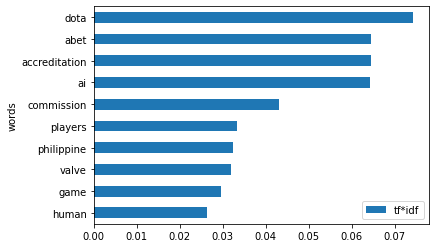

In [45]:
df = pd.DataFrame({'words': words, 'tf*idf': values})
ax = df.plot.barh(x='words', y='tf*idf')
ax